In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


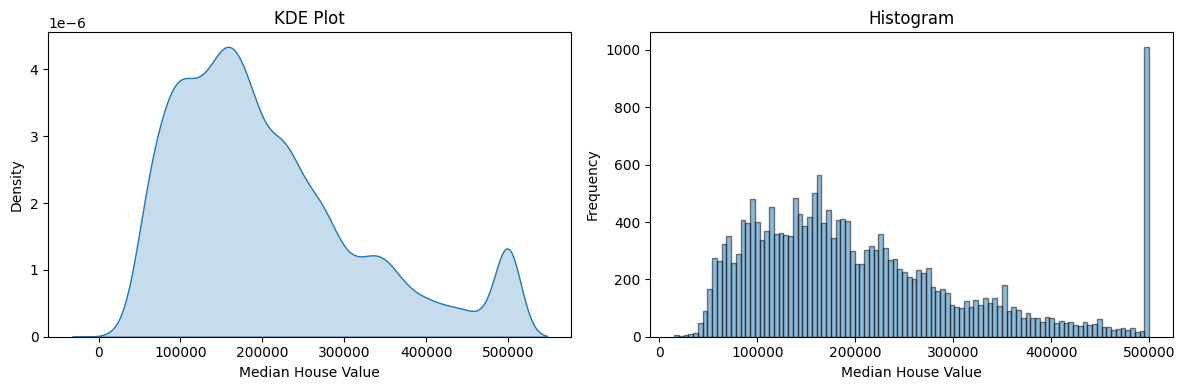

In [3]:
# target column distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(data['median_house_value'], fill=True, ax=axes[0])
axes[0].set_xlabel('Median House Value')
axes[0].set_ylabel('Density')
axes[0].set_title('KDE Plot')

axes[1].hist(data['median_house_value'], bins=100, edgecolor='k', alpha=0.5)
axes[1].set_xlabel('Median House Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


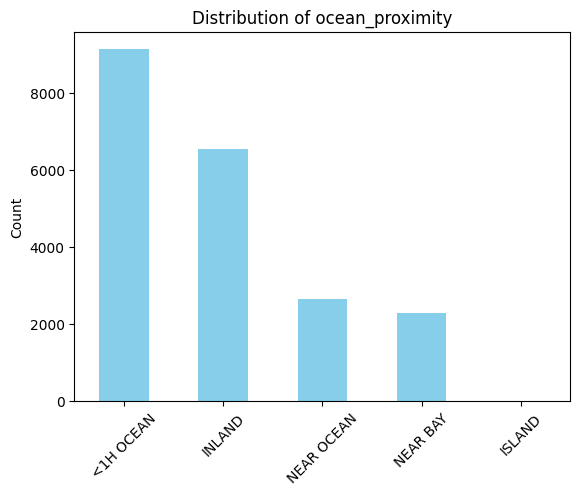

In [4]:
value_counts = data['ocean_proximity'].value_counts()
print(value_counts)
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of ocean_proximity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Preparing the dataset**

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [5]:
proximity = ['<1H OCEAN', 'INLAND']
data = data[data['ocean_proximity'].isin(proximity)]

In [6]:
missing_values = data.isna().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
total_bedrooms    157
dtype: int64


In [7]:
data['total_bedrooms'].fillna(0.0, inplace=True)
data['median_house_value'] = data['median_house_value'].map(lambda x: np.log1p(x))

In [8]:
train, val_test = train_test_split(data, test_size=0.4, random_state=1)
val, test = train_test_split(val_test, test_size=0.5, random_state=1)

In [9]:
y_tr = train['median_house_value']
y_val = val['median_house_value']
y_test = test['median_house_value']

dict_train = train.drop(columns=['median_house_value']).to_dict(orient="records")
dv = DictVectorizer(sparse = False)
dv.fit(dict_train)

X_tr = dv.transform(dict_train)

dict_val = val.drop(columns=['median_house_value']).to_dict(orient="records")
X_val = dv.transform(dict_val)

dict_test = test.drop(columns=['median_house_value']).to_dict(orient="records")
X_test = dv.transform(dict_test)

In [10]:
list(dv.get_feature_names_out())

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [11]:
X_tr[0]

array([ 4.9200e+02,  2.3000e+01,  3.7530e+01, -1.2196e+02,  4.2955e+00,
        1.0000e+00,  0.0000e+00,  1.2780e+03,  4.7500e+02,  2.2150e+03])

In [12]:
train.iloc[0]

longitude               -121.96
latitude                  37.53
housing_median_age         23.0
total_rooms              2215.0
total_bedrooms            475.0
population               1278.0
households                492.0
median_income            4.2955
median_house_value    12.295918
ocean_proximity       <1H OCEAN
Name: 896, dtype: object

In [13]:
linear_model = LinearRegression()
linear_model.fit(X_tr, y_tr)

y_pred = linear_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error: 0.31579792487345915
R-squared (R2) Score: 0.6843330353124095


# Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?

In [14]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_tr, y_tr)

DecisionTreeRegressor(max_depth=1)

In [15]:
y_pred = dt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R-squared (R2) Score:", r2)

RMSE: 0.45619929333044296
R-squared (R2) Score: 0.3560537601671484


In [16]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# Question 2

Train a random forest model with these parameters:

n_estimators=10

random_state=1

n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [17]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_tr, y_tr)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("R-squared (R2) Score:", r2)

RMSE: 0.2354333211555584
R-squared (R2) Score: 0.824552797166149


# Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.

- Set random_state to 1.

- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [19]:
for num_estimators in range(10, 201, 10):
    print(f'n_estimators = {num_estimators}')
    rf = RandomForestRegressor(n_estimators=num_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_tr, y_tr)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f'RMSE:, {rmse: .3f}')
    print(f'R-squared (R2) Score:, {r2: .3f}')
    print('-----------------------------')

n_estimators = 10
RMSE:,  0.235
R-squared (R2) Score:,  0.825
-----------------------------
n_estimators = 20
RMSE:,  0.227
R-squared (R2) Score:,  0.837
-----------------------------
n_estimators = 30
RMSE:,  0.224
R-squared (R2) Score:,  0.842
-----------------------------
n_estimators = 40
RMSE:,  0.223
R-squared (R2) Score:,  0.842
-----------------------------
n_estimators = 50
RMSE:,  0.222
R-squared (R2) Score:,  0.845
-----------------------------
n_estimators = 60
RMSE:,  0.222
R-squared (R2) Score:,  0.844
-----------------------------
n_estimators = 70
RMSE:,  0.221
R-squared (R2) Score:,  0.845
-----------------------------
n_estimators = 80
RMSE:,  0.221
R-squared (R2) Score:,  0.846
-----------------------------
n_estimators = 90
RMSE:,  0.221
R-squared (R2) Score:,  0.845
-----------------------------
n_estimators = 100
RMSE:,  0.221
R-squared (R2) Score:,  0.846
-----------------------------
n_estimators = 110
RMSE:,  0.220
R-squared (R2) Score:,  0.847
----------------

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]

- For each of these values,

    try different values of n_estimators from 10 till 200 (with step 10)

    calculate the mean RMSE

- Fix the random seed: random_state=1

- What's the best max_depth, using the mean RMSE?

In [20]:
for depth_bound in [10, 15, 20, 25]:
    rmse_values = np.array([])
    for num_estimators in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=num_estimators, 
            max_depth=depth_bound,
            random_state=1, 
            n_jobs=-1
            )
        rf.fit(X_tr, y_tr)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_values = np.append(rmse_values, rmse)
    print(f'max_depth = {depth_bound}, mean rmse for different n_estimators values: {np.mean(rmse_values)}')

max_depth = 10, mean rmse for different n_estimators values: 0.23295049753672065
max_depth = 15, mean rmse for different n_estimators values: 0.22295567175154604
max_depth = 20, mean rmse for different n_estimators values: 0.22184286481445126
max_depth = 25, mean rmse for different n_estimators values: 0.2219243875453157


# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:

        n_estimators=10,

        max_depth=20,

        random_state=1,

        n_jobs=-1 (optional)

- Get the feature importance information from this model

What's the most important feature (among these 4)?

- total_rooms

- median_income

- total_bedrooms

- longitude


In [21]:
rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=20,
    random_state=1, 
    n_jobs=-1
    )
rf.fit(X_tr, y_tr)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.23500018434982684


In [22]:
features = dv.get_feature_names_out()
gini_importance = pd.DataFrame({'Feature': features, 'GINI importance': rf.feature_importances_} )
gini_importance

,Feature,GINI importance
0,households,0.018251
1,housing_median_age,0.032312
2,latitude,0.096886
3,longitude,0.084879
4,median_income,0.338376
5,ocean_proximity=<1H OCEAN,0.290405
6,ocean_proximity=INLAND,0.069018
7,population,0.028251
8,total_bedrooms,0.017134
9,total_rooms,0.024489


# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:


```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

In [23]:
features = [element.replace('=', '').replace('<', '') for element in features]
dtrain = xgb.DMatrix(X_tr, label = y_tr, feature_names=features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names=features)

In [24]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.24423635709573743


In [25]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.32094502345384696
